In [1]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))
import encoding

INPUT_LENGTH = 90
OUTPUT_LENGTH = 90


In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data pre-processing

In [3]:
data = pd.read_csv('../datasets/hospital_augment_train6_3.csv')
data = data.sample(frac=1, random_state=0)

data_input = list(data['gen_data'])
data_output_temp = list(data['true_data'])
data_output = ["\t"+s for s in data_output_temp]

print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)
a = int(data_size*90/100)

# We will use the first 0-60th %-tile (60%) of data for the training
training_input  = data_input[:a]
training_output = data_output[:a]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_input = data_input[a:]
validation_output = data_output[a:]

print('training size', len(training_input))
print('validation size', len(validation_input))

โรงพยาบลเทิง 	โรงพยาบาลเทิง
โรงพยาบลปะคำ 	โรงพยาบาลปะคำ
training size 77136
validation size 8571


In [4]:
data_output[0]

'\tโรงพยาบาลเทิง'

### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [5]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('Input character dict size:', input_dict_size)
print('Output character dict size:', output_dict_size)


encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

Input character dict size: 94
Output character dict size: 84
encoded_training_input (77136, 90)
encoded_training_output (77136, 90)
encoded_validation_input (8571, 90)
encoded_validation_output (8571, 90)


# Sequence-to-Sequence in Keras

In [6]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [7]:
encoder_input.shape

TensorShape([None, 90])

In [8]:
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Attention,RepeatVector,Input,concatenate,TimeDistributed

### Encoder / Decoder

In [9]:
from tensorflow.keras.layers import SimpleRNN,Bidirectional,Concatenate
# Bidirectional LSTM or Simple LSTM
units =128
encoder_emb = Embedding(input_dict_size, units, input_length=INPUT_LENGTH,mask_zero=True)

encoder_lstm = Bidirectional(LSTM(units=units, return_sequences=True, return_state=True)) # Bidirectional

encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_input))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])

encoder_states = [state_h, state_c]

In [10]:
#decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=output_dict_size, output_dim=64)
decoder_lstm = LSTM(units=units*2, return_sequences=True, return_state=True) # units=units*2
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_input), initial_state=encoder_states)

In [11]:
encoder_out.shape,decoder_lstm_out.shape

(TensorShape([None, 90, 256]), TensorShape([None, 90, 256]))

In [12]:
from tensorflow.keras.layers import Activation, dot, concatenate,Attention

attention = dot([encoder_out, decoder_lstm_out], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
context = dot([attention, encoder_out], axes=[2,1])
print('context', context)

context Tensor("dot_1/Identity:0", shape=(None, 90, 256), dtype=float32)


In [13]:
decoder_combined_context = concatenate([context, decoder_lstm_out])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)

decoder_combined_context Tensor("concatenate_2/Identity:0", shape=(None, 90, 512), dtype=float32)
output Tensor("time_distributed_1/Identity:0", shape=(None, 90, 84), dtype=float32)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [14]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 90, 128)      12032       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 90, 256), (N 263168      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 90)]         0                                            
______________________________________________________________________________________________

## Training the model

In [16]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [414]:
training_decoder_input[0,:]

array([ 1, 16, 65, 45, 31, 33, 18, 23, 86, 23, 39, 86, 46, 23, 57, 76, 33,
       46, 42, 14, 23, 25, 23, 33, 45, 46, 37, 63, 63, 78, 52, 45,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [415]:
encoded_training_output[0,:]

array([16, 65, 45, 31, 33, 18, 23, 86, 23, 39, 86, 46, 23, 57, 76, 33, 46,
       42, 14, 23, 25, 23, 33, 45, 46, 37, 63, 63, 78, 52, 45,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [17]:
'''
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)
'''
hist = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=20)

#model.save('model_v2.h5')

Train on 77136 samples, validate on 8571 samples
Epoch 1/20
77136/77136 - 320s - loss: 0.6098 - val_loss: 0.3750
Epoch 2/20
77136/77136 - 287s - loss: 0.2543 - val_loss: 0.1636
Epoch 3/20


KeyboardInterrupt: 

In [18]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'loss')

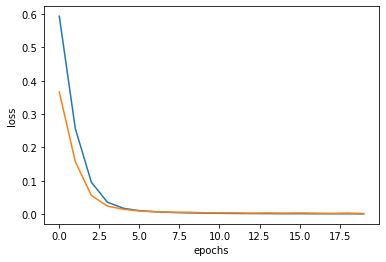

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [447]:
encoder_input.shape

(1, 90)

In [340]:
state_input_h = Input(shape=(units*2,), name="state_input_h") # units*2 if Bidirectional LSTM else units*1
state_input_c = Input(shape=(units*2,), name="state_input_c") # units*2
inf_decoder_inputs = Input(shape=(INPUT_LENGTH, units*2), name="inf_decoder_inputs")
# similar decoder model architecture with state from encoder model
decoder_res, decoder_h, decoder_c = decoder_lstm(decoder_emb(decoder_input),
                                                 initial_state=[state_input_h, state_input_c])

In [341]:
inf_decoder_inputs.shape,decoder_res.shape

(TensorShape([None, 90, 128]), TensorShape([None, 90, 128]))

In [342]:
# Attention inference
attention = dot([inf_decoder_inputs, decoder_res], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
context = dot([attention, encoder_out], axes=[2,1])
# Concat attention input and decoder LSTM output
decoder_out_concat_res = Concatenate(axis=-1, name='concat_layer')([decoder_res, context])

In [348]:
decoder_input.shape,inf_decoder_inputs.shape

(TensorShape([None, 90]), TensorShape([None, 90, 128]))

In [350]:
state_input_c.shape,state_input_c.shape

(TensorShape([None, 128]), TensorShape([None, 128]))

In [356]:

decoder_d1 = TimeDistributed(Dense(units, activation="relu"))
decoder_d2 = TimeDistributed(Dense(output_dict_size, activation="softmax"))
inf_decoder_out = decoder_d2(decoder_d1(decoder_out_concat_res))
# finalizing the deocder model

inf_model = Model(inputs=([decoder_input] + [inf_decoder_inputs,  state_input_h, state_input_c]), 
                  outputs=[inf_decoder_out, decoder_h, decoder_c], name = 'Decoder')


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_7:0", shape=(None, 90), dtype=float32) at layer "input_7". The following previous layers were accessed without issue: ['input_8', 'embedding_9', 'state_input_h', 'state_input_c', 'lstm_9']

In [354]:
 b= [decoder_input]+[inf_decoder_inputs,  state_input_h, state_input_c]

[<tf.Tensor 'input_8:0' shape=(None, 90) dtype=float32>,
 <tf.Tensor 'inf_decoder_inputs_6:0' shape=(None, 90, 128) dtype=float32>,
 <tf.Tensor 'state_input_h_6:0' shape=(None, 128) dtype=float32>,
 <tf.Tensor 'state_input_c_6:0' shape=(None, 128) dtype=float32>]

In [239]:
decoder_input.shape,inf_decoder_inputs.shape

(TensorShape([None, 90]), TensorShape([None, 90, 128]))

### Testing the model


In [20]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    text_list =[]
    for i in sequence:
        if i != 0:
            text += output_decoding[i]
            text_list.append(output_decoding[i])
    return text,text_list

def to_katakana(text):
    decoder_output = generate(text)
    txt,lst = decode(output_decoding, decoder_output[0])
    return txt,lst

In [22]:
k=data_input[:10]

In [290]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

In [305]:
text = k[0]

In [460]:
encoder_input = encoding.transform(input_encoding, [text], 90)
decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
decoder_input[:,0] = encoding.CHAR_CODE_START

In [422]:
a= [encoder_input, decoder_input]

In [423]:
a

[array([[73, 48, 34, 36, 17, 22, 93, 22, 43, 93, 49, 22, 63, 83, 36, 49,
         46, 14, 22, 26, 22, 36, 48, 49, 41, 70, 70, 85, 57, 48,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [461]:
 for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
        #print(output[:,i])

In [21]:
pred_out =[]
for name in k:
    a,b =to_katakana(name)
    print(name, a)
    pred_out.append(to_katakana(name))

NameError: name 'k' is not defined

In [426]:
data_test = pd.read_csv('../datasets/hospital_augment_test6_3.csv', header=None)

In [427]:
data_input_test = [s for s in data_test[0]]
data_output_test = [s for s in data_test[1]]

In [428]:
for i in range(10):
    a,b =to_katakana(data_input_test[i])
    out = data_output_test[i]
    print(data_input_test[i],'>', a,'>',out)

gen_data > ttttธรผ2 > true_data
คลินิกกรุงเ3ทพพัทยาสาขาจอมเทียน > คินิิกรกุพพะอสเพยยยสอ > คลินิกกรุงเทพพัทยาสาขาจอมเทียน
คลินิชกกุงเทพระยองส"าขาบ่อวิน > คคิิกรกรุเโยยรยสพ(อสุวไย > คลินิกกรุงเทพระยองสาขาบ่อวิน
คลินิกชรุงเทพระยองสาขาปลวกแดง > คิิิ์รรพยสเยยสลแุอ > คลินิกกรุงเทพระยองสาขาปลวกแดง
คลินิกไท์ยอินเตอร์การแพ&ยท(เกาะพงัน) > คิิิิศไไยร(ิรยรนรศอ > คลินิกไทยอินเตอร์การแพทย์(เกาะพงัน)
คลินิกรักสโขภาพจ.ระยอง > คิิิิรร.ัไ ยรพยย > คลินิกรักสุขภาพจ.ระยอง
คลินิกโรงพยาบาลกรุงเทพพัทยฮาสาขานาเ"ลโือ > คาน์โอเยันุ > คลินิกโรงพยาบาลกรุงเทพพัทยาสาขานาเกลือ
คลินิกโรงทยาบาลกรุงเทพพัทยาสาขาบุญสัมพันธ์ > คิิิิิรรพพไพยยาัยาัาุสเยุุพ > คลินิกโรงพยาบาลกรุงเทพพัทยาสาขาบุญสัมพันธ์
คลินิกโงพยาบาลกร6ุงเทพสม"ุย > คิิิิิรรพพพยยบลยสเกรย > คลินิกโรงพยาบาลกรุงเทพสมุย
คลินิกโรงพฒญาบาลสมิติเวชศรีราชา(อีส3เทิร์นซีบอร์ด) > คิิิิรรรพ ยยพ าเยรเยเ(อ > คลินิกโรงพยาบาลสมิติเวชศรีราชา(อีสเทิร์นซีบอร์ด)


In [191]:
t1 = generate(text)

In [192]:
t1

array([[65., 31., 65., 65., 65., 65.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [240]:
encoder_input = encoding.transform(input_encoding, [text], 90)
decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
#decoder_input2 = encoding.transform(output_encoding,[text],90)
decoder_input[:,0] = encoding.CHAR_CODE_START

In [246]:
for i in range(1, OUTPUT_LENGTH):
    output = model.predict([encoder_input, decoder_input])
    idx = output.argmax(axis=2)
    decoder_input[:,i] = idx[:,i]
    a = idx[:,i]
    print(output_decoding[a[0]])

โ
ี
อ
ี
ท
อ
ร
ี
อ
ี
แ
ท
ร
ฐ
ร
ท
ฎ
ฎ
๋
ู
ี
ท
8
ท
้
ท
ฎ
ต
ู
ู
ต
ค
ู
ต
a
ฎ
7
้
ี
)
ะ
อ
ี
ท
ร
ท
ฎ
ต
ฎ
ฆ
ู
ต
ค
ต
ั
ผ
ต
ผ
ะ
ฬ
ฬ
ค
้
ต
ู
ต
ค
a
ู
ี
ท
ฎ
ฎ
๋
ต
ณ
ั
ฬ
ฬ
ต
ฬ
ค
ะ
ต
ค
์
น
ท
ค


In [245]:
output_decoding[85]

'ฝ'

In [66]:
x1= np.reshape(training_encoder_input[9,:],(1,90))
x2= np.reshape(training_decoder_input[9,:],(1,90))

In [68]:
out  =model.predict([x1,x2])

In [69]:
idx = out.argmax(axis=2)

In [70]:
lst = []
for i in range(idx.shape[1]):
    a = idx[0,i]
    if a != 0:
        lst.append(output_decoding[a])

In [71]:
''.join(lst[1:])

'คลินิกกรุงเทพระยองสาขาบ้านฉาง'

In [429]:
result = model.predict([training_encoder_input,training_decoder_input])

In [430]:
index_result = result.argmax(axis=2)

In [122]:
index_result.shape

(77137, 90)

In [431]:
lst_output =[]
for i in range(10000):
    temp = []
    for j in range(index_result.shape[1]):
        a = int(index_result[i,j])
        if a != 0:
            temp.append(output_decoding[a])
    lst_output.append(temp[1:])

In [432]:
### Input, Predict, Target ###
pred_sent = []
count = 0
for i in range(1000):
    print(data_input[i],'>', ''.join(lst_output[i]), '>', data_output[i])
    a = data_output[i]
    pred_sent.append(''.join(lst_output[i]))
    if str(''.join(lst_output[i])) == a[1:]:
        count +=1

องเลยราม
โรงพยาๆาลหลวงพ่ทวีศักดิ์ ชุผินธโร อุทิ > โรงพยาบาลหลวงพ่อทวีศักดิ์ ชุตินธโร อุทิศ > 	โรงพยาบาลหลวงพ่อทวีศักดิ์ ชุตินธโร อุทิศ
สหคลินิกกลว้ยน้าไท้าขาราม2 > สหคลินิกกล้วยน้ำไทสาขาราม2 > 	สหคลินิกกล้วยน้ำไทสาขาราม2
โรงพยาบาลมหาชัย2 > โรงพยาบาลมหาชัย2 > 	โรงพยาบาลมหาชัย2
โรูพยาบาลเชียงดาว > โรงพยาบาลเชียงดาว > 	โรงพยาบาลเชียงดาว
โรงพยาบาลศรีสมเด็ > โรงพยาบาลศรีสมเด็จ > 	โรงพยาบาลศรีสมเด็จ
โรงพยาบาลหริภุญชัยเฝมโมเรียล > โรงพยาบาลหริภุญชัยเมโมเรียล > 	โรงพยาบาลหริภุญชัยเมโมเรียล
โรงพยาบาลเกะคา > โรงพยาบาลเกาะคา > 	โรงพยาบาลเกาะคา
โรงพยาบาลกงไกรฺาศ > โรงพยาบาลกงไกรลาศ > 	โรงพยาบาลกงไกรลาศ
โรงพยาบาลสองพฺ่น้4อง > โรงพยาบาลสองพี่น้อง > 	โรงพยาบาลสองพี่น้อง
โรงขพยาบาลพระปกเกล้า > โรงพยาบาลพระปกเกล้า > 	โรงพยาบาลพระปกเกล้า
โรงฌยาบาลบางบ่อ > โรงพยาบาลบางบ่อ > 	โรงพยาบาลบางบ่อ
โรงพยาบาลถนาตาล > โรงพยาบาลนาตาล > 	โรงพยาบาลนาตาล
โรงพาบาลเปาโลเมโมเรียล > โรงพยาบาลเปาโลเมโมเรียล > 	โรงพยาบาลเปาโลเมโมเรียล
โรงพย)บาลหนองเรือ > โรงพยาบาลหนองเรือ > 	โรงพยาบาลหนองเรือ
โรงพยาบาลโนนไทย > โรงพยาบาลโนนไ

In [173]:
pred_sent[555],data_output[555]

('โรงพยาบาลภูกาง', '\tโรงพยาบาลภูซาง')

In [441]:
text = 'โรงพยาบาลพานทอง'

In [442]:
to_katakana(text)

('โรพพาาาลพพไท', ['โ', 'ร', 'พ', 'พ', 'า', 'า', 'า', 'ล', 'พ', 'พ', 'ไ', 'ท'])

In [180]:
encoded_training_output_sample = encoding.transform(
    output_encoding, [text] ,vector_size=OUTPUT_LENGTH)

In [182]:
encoded_training_output_sample.shape

(1, 90)

In [183]:
encoded_training_output.shape

(77137, 90)

In [90]:
decoder_input[:,0] = encoding.CHAR_CODE_START

In [96]:
output = model.predict([encoder_input, decoder_input]).argmax(axis=2)

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [73]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[9] == model.get_layer('attention'))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000238DF371088>	name:input_1
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002388A170748>	name:embedding
<tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x00000238DF371908>	name:bidirectional
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000238DF371048>	name:input_2
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002388A16CC08>	name:embedding_1
<tensorflow.python.keras.layers.merge.Concatenate object at 0x000002388A17E488>	name:concatenate
<tensorflow.python.keras.layers.merge.Concatenate object at 0x000002388A170D08>	name:concatenate_1
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000002388A16CBC8>	name:lstm_1
<tensorflow.python.keras.layers.merge.Dot object at 0x000002389170D808>	name:dot
<tensorflow.python.keras.layers.core.Activation object at 0x00000238916FF148>	name:attention
<tensorflow.python.keras.layers.merge.Do

We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [74]:
attention_layer = model.get_layer('attention') # or model.layers[7]
#attention_layer = model.layers[8]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 90, 91), (None, 90, 90)]


In [440]:
model

In [133]:
output, attention,weight=attention_model.predict([encoder_input, decoder_input])

In [433]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn
#plt.rcParams

seaborn.set(font=['Tahoma'], font_scale=1)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text], 90)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(20,10))
    ax = seaborn.heatmap(attention_density[:len(katakana[0]), :len(text)+1],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana[0]])

    ax.invert_yaxis()
    plt.show()


<Figure size 432x288 with 0 Axes>

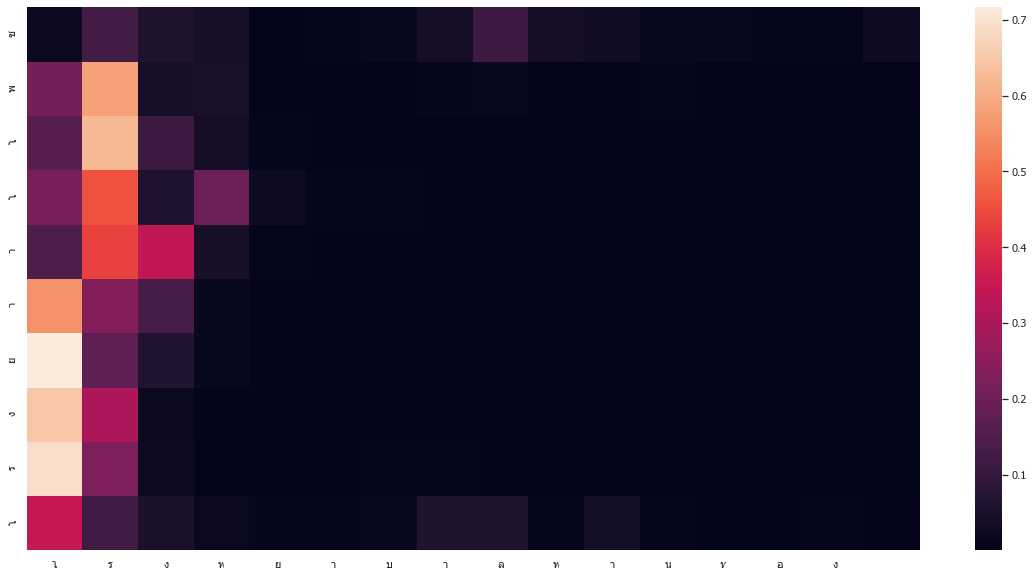

In [436]:
visualize('โรงพยาบาลพานทอง')